The focus of this notebook is to show the performance of a model that predicts Loudness on impact ruling out Soap slipperiness as suggested by the Granger Causality test

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Load the dataset
dataset = pd.read_csv('../input/training/Training.csv')
print(dataset.shape)
dataset.head()
df=dataset.loc[:, dataset.columns != 'Soap slipperiness']
df.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,3.47672


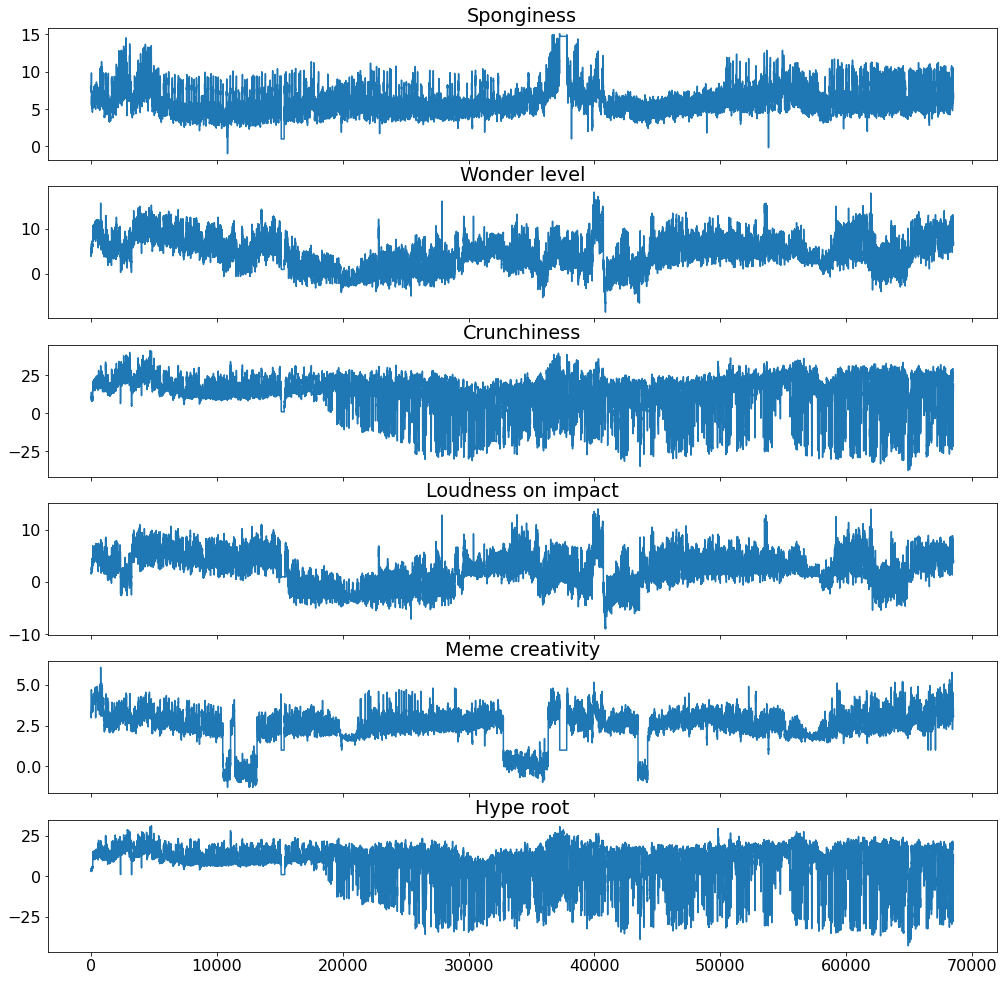

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(df, df.columns)

In [ ]:
window = 300
stride = 15

In [ ]:
future = df[-window:]
future = np.expand_dims(future, axis=0)
future.shape

(1, 300, 6)

In [ ]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
target_labels = df.columns
telescope = 150

In [ ]:
X_train, y_train = build_sequences(df, target_labels, window, stride, telescope)
X_train.shape, y_train.shape

((4550, 300, 6), (4550, 150, 6))

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        print(col)
        if(col != "Loudness on impact"):
            axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
            #axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        else:
            axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
            axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,0], color='orange')
        axs[i].set_title(col)
        #axs[i].set_ylim(0,1)
    plt.show()

Sponginess
Wonder level
Crunchiness
Loudness on impact
Meme creativity
Hype root


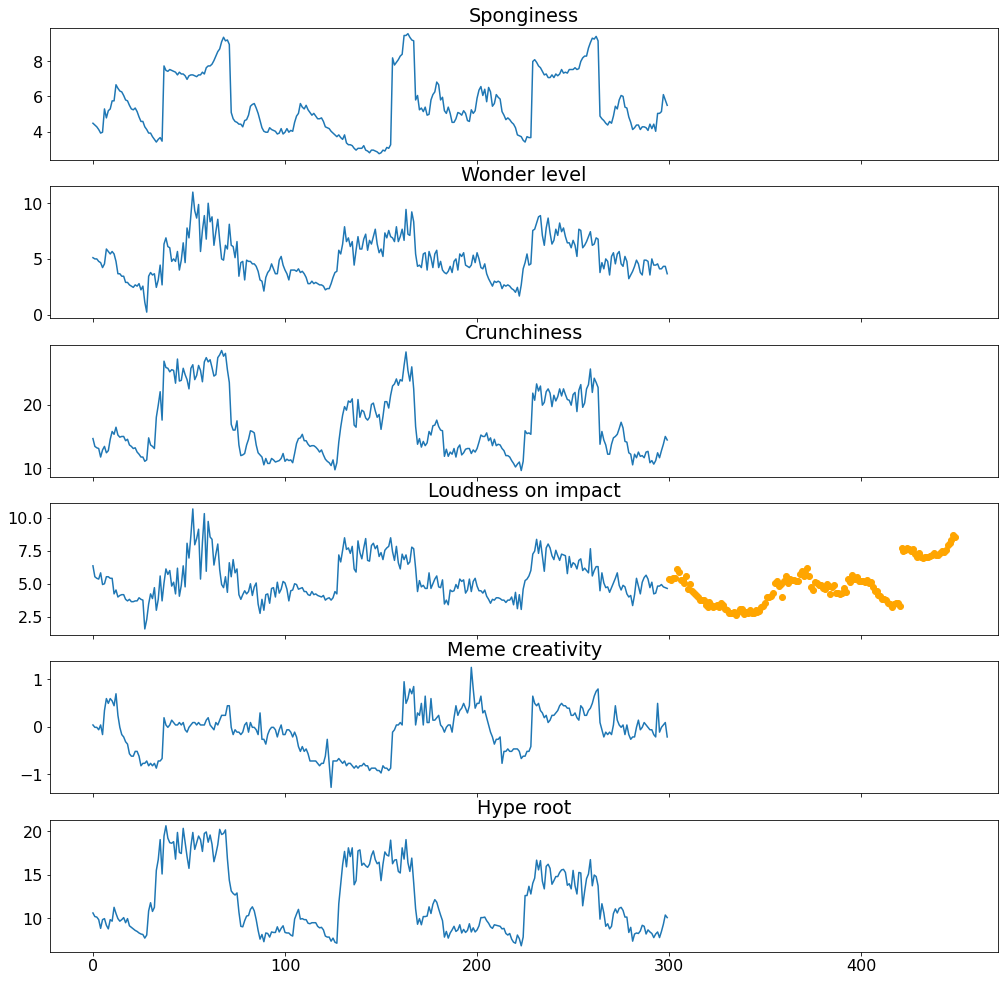

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

2022-01-02 12:23:24.852031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 12:23:24.944446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 12:23:24.945142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 12:23:24.946224: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 300, 6)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          36352     
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 128)          49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 256)          263168    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 256)          196864    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0     

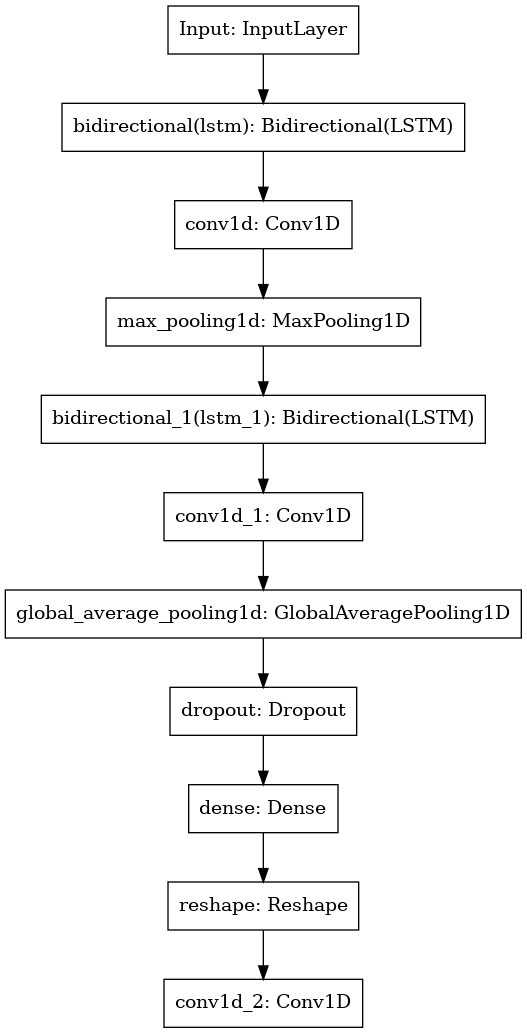

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

2022-01-02 12:23:29.292371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-02 12:23:34.731957: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


64/64 [==============================] - 16s 78ms/step - loss: 70.0919 - mae: 6.1416 - val_loss: 90.2497 - val_mae: 6.5028
Epoch 2/200
64/64 [==============================] - 3s 53ms/step - loss: 47.8317 - mae: 4.6451 - val_loss: 81.9863 - val_mae: 5.5672
Epoch 3/200
64/64 [==============================] - 3s 54ms/step - loss: 41.9652 - mae: 4.0408 - val_loss: 79.6470 - val_mae: 5.1346
Epoch 4/200
64/64 [==============================] - 3s 53ms/step - loss: 40.2801 - mae: 3.8122 - val_loss: 77.7144 - val_mae: 5.0499
Epoch 5/200
64/64 [==============================] - 3s 52ms/step - loss: 37.8867 - mae: 3.6727 - val_loss: 67.3246 - val_mae: 4.7210
Epoch 6/200
64/64 [==============================] - 3s 53ms/step - loss: 32.0136 - mae: 3.4615 - val_loss: 48.6585 - val_mae: 4.2066
Epoch 7/200
64/64 [==============================] - 3s 53ms/step - loss: 26.6077 - mae: 3.2182 - val_loss: 44.3854 - val_mae: 4.0078
Epoch 8/200
64/64 [==============================] - 3s 53ms/step - loss:

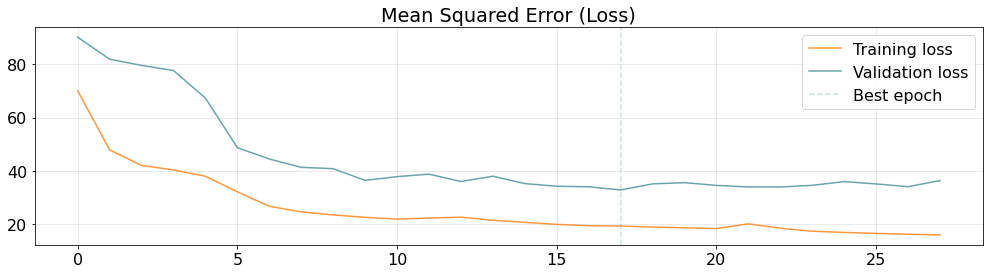

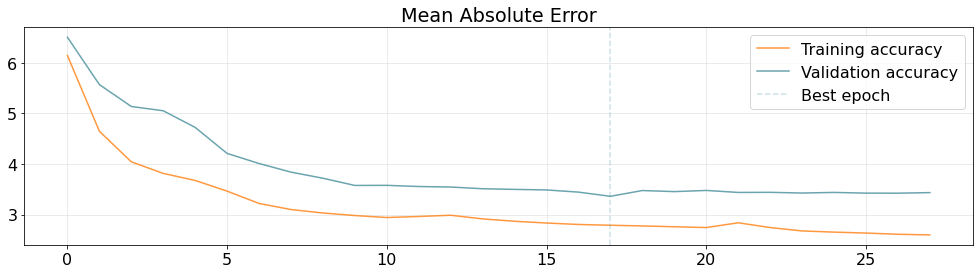

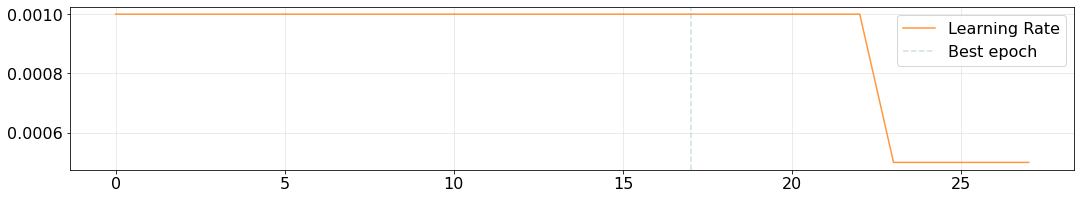

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Loudness_predictorAllData')
#model = tfk.models.load_model('DirectForecasting')

2022-01-02 12:26:05.636723: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Test evaluation

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

Predict the future 

In [ ]:
X_temp = df[-window:]
print(X_temp.shape)
X_temp=np.reshape(X_temp,(window,-1))
print(X_temp.shape)
X_temp=np.expand_dims(X_temp, axis=0)
print(X_temp.shape)

reg_future = np.array([])
X_temp = future
for reg in range(0,864,telescope):
    pred_temp = model.predict(X_temp)
    print(pred_temp.shape)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = tf.concat([X_temp[:, telescope:, :], pred_temp], axis=1)
out=reg_future[0,:864,:]

(300, 6)
(300, 6)
(1, 300, 6)
(1, 150, 6)
(1, 150, 6)
(1, 150, 6)
(1, 150, 6)
(1, 150, 6)
(1, 150, 6)


(300,)


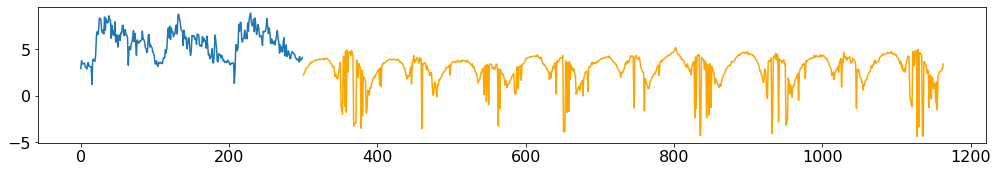

In [ ]:
plt.figure(figsize=(17,2.5))
X_temp = df["Loudness on impact"]
X_temp= X_temp[-window:]
print(X_temp.shape)
#X_temp=np.reshape(X_temp,(window,-1))
#print(X_temp.shape)
X_temp=np.expand_dims(X_temp, axis=0)
plt.plot(np.arange(len(X_temp[0,:])), X_temp[0,:])
plt.plot(np.arange(len(X_temp[0,:]), len(X_temp[0,:])+864), out[:,3], color='orange')
    #axs[i].fill_between(
       # np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
       # reg_future[0,:,i]+maes[:,i], 
       # reg_future[0,:,i]-maes[:,i], 
        #color='orange', alpha=.3)
    #axs[i].set_title(col)
   # axs[i].set_ylim(0,1)
plt.show()